# DPA attack on AES cryptosystem
In this notebook you will learn about AES and how we can find the secret key using a differential power analysis attack

**Goals:**
* Learn what AES is and how it works
* Learn about leakage bits
* Perform a DPA attack on AES

#### Prerequisites
- [x] *0_series* notebooks 
- [x] *1_series* notebooks

## AES - Advanced Encryption Standard
As mentioned in the previous notebook, AES is a symmetric cryptosystem. That means to encrypt and decrypt messages the same secret key must be used. The version of AES we will program on the target is AES128. The 128 means that the secret key is 128 bits (= 16 bytes) long. To encrypt a message with AES, the message is split into pieces as large as the key. Those pieces are then encrypted separately to eventually end up with a fully encrypted text. For simplicity sake we will just use messages that are the same size as the key to find that secret key.

### How to attack AES
In order to encrypt plain text (16 bytes long) the AES-algorithm encrypts each byte at a time using the corresponding byte in the key. Let's look at a little visualization: e.g.
```
    secret_key = 0x01 23 45 67 .. (16 bytes long)
    plain_text = 0xAB CD EF 98 .. (16 bytes long)
    
    1)The first byte of the key is used to encrypt the first byte of the plain text:
        0x01 is used to encrypt 0xAB
    
    2) The second byte of the key is used to encrypt the second byte of the plain text:
        0x23 is used to encrypt 0xCD
    
    3) The third byte of the key is used to encrypt the third byte of the plain text.
    
    .
    .
    .
    
    16) The last byte of the key is used to encrypt the last byte of the plain text.
```

The beauty of the atttack we are going to perform is that we can use this implementation of AES to figure out the secret key 1 byte at a time by trying all different possibilities that a byte can be. You might think that this is the same as just trying every possible key but let's quickly look at the maths.
```
    Trying to guess the full 16 byte key at once:
        There are 2^(16*8) possibilities = 3.4028237*10^38
    
    But what if we try to guess each byte seperately:
        There are 2^(1*8) possibilities per byte = 256
        We need to find 16 bytes, so the total amount of possibilities is 256*16 = 4096
        
Compared to 3.4*10^38 the number 4096 is really small. More importantly, it is small enough to let a computer try all those 4096 possibilities in just a couple of seconds.
```
All right, the important thing we need to know now is how we decide if our guess for the key was correct or not. We will never be able to tell from one guessed byte if it was the correct one or not. But we can look at the system while it is checking our guesses (side channel analysis). If we compare our observations for every guess we will see that with one of our guesses the system will behave differently, because that guess was correct. The thing we will be observing is the power consumption of the device. That train of thought is how we will be able to recover the hidden key in the target.

To know exactly how we are going to practically do this, keep reading.

### Inner workings of AES
In order to perform a successful attack later on we need to know a bit more about how AES encryts/decrypts each byte. (to follow along see the image below) In the first steps the plain text byte is `XOR`'ed with the key byte. That produces a new byte (the `xor_byte`) that is used to look up a value in a predetermined `SBOX`. An SBOX is nothing more than a table with 16\*16 values. The SBOX produces a new byte (the `sbox_byte`) by taking the value stored at the following position in the SBOX: `SBOX[first_4_bits_xor_byte][last_4_bits_xor_byte]`. That sbox_byte is then encrypted even further, but what we know, is already enough to perform a decent attack!

<img src="../src/images/aes_byte_encrypt.png" alt="AES start encryption of a byte" width=800>

With this information we can write a simple function `aes_internal` that returns the `sbox_byte` for a given `inputdata` and `key`. The contents of the SBOX is not secret so we will provide you with the correct SBOX:

In [6]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

In [7]:
def aes_internal(inputdata, key):
    # write your code below this line
    ###BEGIN SOLUTION### 
    return sbox[inputdata ^ key]
    ###END SOLUTION###

# The following assertions will test your function
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


#### Cracking our own little aes secret
The code block below defines a function called `aes_secret` wich takes some input text and performs the first steps of AES on it with a set key. We will now perform attacks on this version of the AES algorithm to find the hidden key. (Later we are again going to use real power measurements)

In [8]:
def aes_secret(inputdata):
    secret_key = 0xEF    # The secret key we will try to find
    return aes_internal(secret_key, inputdata)

At this point, we can get the value of some internal part of the AES algorithm. We can now look at what the output of the SBOX will be for many different inputs. For our first attack, we're going to assume that we can't observe the entire value of the `sbox_byte`. Let's just observe a single bit of the value - imagine that someone put a probe down inside the chip to get this. We can do this by simply throwing away all the other data besides a single bit, and only expose that single bit to the observer.

To look at a specific bit we will use an `aes_watcher` function. The watcher is going to observe that single bit of data. We'll need to build lists of input we feed to AES (we're just going to send in 1000 random bytes that get 'encrypted'), as well as lists to hold our observation of the bit we are observing for each input.

* 1. Your first objective is to build a list of data you are encrypted with `aes_secret()`. This should be a 1000-item list where the value of each item ranges from 0 to 255. Call it `input_data`. For example if you print the input_data list it could look like \[2, 49, 0, 212, 94, 255, ... , 7\], where there are 1000 elements in total: 

* 2. Now, feed all those inputs through the aes_secret function. Because this is a 'secret' function we are only going to observe a single bit of output (the 'leakage bit'). The provided code will perform the encryptions and mask off all but the lowest bit for you, and build a new array called leaked_data which contains just the 1 or 0 status of the lowest bit. (that way the output_leak_bit at index 0 of the leaked_data array will be the leaked bit corresponding with the input from the array input_data at index 0)

In [9]:
import random
# Write the code down below to create the array 'input_data'
###BEGIN SOLUTION###
input_data = [random.randint(0,255) for _ in range(0, 1000)]
###END SOLUTION###

In [10]:
# provided code that stores a list of the leaked bits
leaked_data = [(aes_secret(a) & 0x01) for a in input_data]
print(leaked_data)
import matplotlib.pylab as plt
plt.plot(leaked_data[0:200])
plt.show()

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 

Now let's analyse the collected data and attack it.

##### AES Guesser attack
Now we have a list of leaked bits that come from the aes we can perform the same analysis with our own `aes_internal` function. We will use the same `input_data` and take a guess for the key. This will again result in an array of leaked bits. You can probably see where we are going. If our guess was correct than both arrays with leaked bits will be identical! Now we figured out how to check if our guess was correct. It is now just a matter of trying every key guess and checking against the original leaked bit array (we can again use SAD for this).

Do it: write some code that uses the `aes_internal` with the same `input_data` array and try every possible guess for the key. Perform SAD on the leaked_data arrays for every guess. If the SAD value is 0 the guess was correct. Name the array that collects all leakage bits per guess `hypothetical_leakage`.

In [11]:
import numpy as np
def SAD(array1, array2):
    diff = np.array(array1)-np.array(array2)
    return np.sum(abs(diff))

guess = 0
# Write your solution below
###BEGIN SOLUTION###
for guess in range(255):
    hypothetical_leakage = [(aes_internal(a,guess) & 0x01) for a in input_data]
    sad_value = SAD(leaked_data,hypothetical_leakage)
    if (sad_value == 0):
        break
###END SOLUTION###

print("I think the key is "+str(hex(guess)))
assert(guess == 0xEF)
print("✔️ OK to continue!")

I think the key is 0xef
✔️ OK to continue!


**This shows us that even by just observing 1 bit of the output, we can uncover a lot of the system** 

### More realistic attack: DPA
You probably think to yourself: "Can we still use this method when we can't observe the output of the real AES internals?" The answer is yes: we'll see how power analysis gives us the ability to observe a given bit.

For the attack we will use data collected from 2500 different input_texts. The code below sets a secret key, saves the input_text in the `textin_array` and saves the corresponding collected traces into the `trace_array` (remember that 1 trace is an array with 5000 measurement points). 
```Python
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()
target.set_key(key)

N = 2500
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 
    
assert(len(trace_array) == 2500)
print("✔️ OK to continue!")
```

Since we are not using the hardware in this SIMULATED notebook, you can run the following code block to load all the data:

In [12]:
import numpy as np
key = np.load('../src/sim_files/2A_1-key.npy')
trace_array = np.load('../src/sim_files/2A_2-trace_array.npy')
textin_array = np.load('../src/sim_files/2A_3-textin_array.npy')

What does this data look like? Try plotting a trace or two here. Some code is already provided to print out what the input text looks like:

<IPython.core.display.Javascript object>


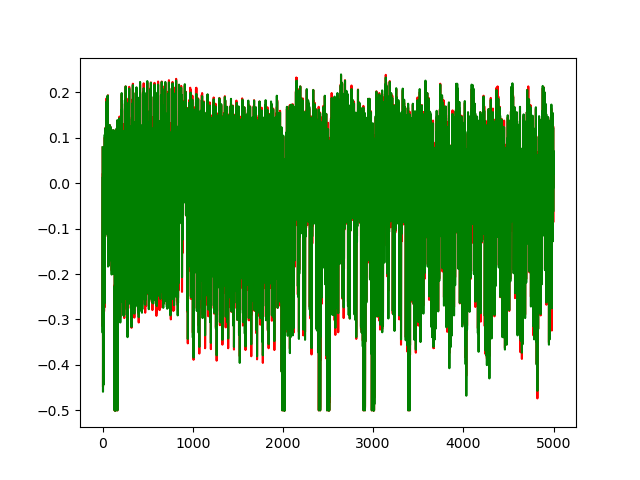

Text looks like this: [ 75 121 122 165  83 224 238  11 239 202 229  35  28  54  79 110]
And this: [123 135  64 243 212 241 220 229 134   4 148 159 181 101 106  63]


In [13]:
%matplotlib notebook
import matplotlib.pylab as plt

# write you code below this line
# ###################
# START SOLUTION
# ###################
plt.figure()
plt.plot(trace_array[0], 'r')
plt.plot(trace_array[1], 'g')
plt.show()
# ###################
# END SOLUTION
# ###################

print('Text looks like this: ' + str(textin_array[0]))
print('And this: ' + str(textin_array[1]))

Remember that AES encrypts byte per byte so we will firstly try to attack the first byte of the key. Later on we will attack the second byte and so on.
```
    byte_to_attack = 0
```
Following the same steps as our previous attack, we should now make a list of leakage_bits probed from the real AES with the real key. However this is no longer possible. Just skip to the second step then because we can still make arrays of hypothetical leakage bits (for keys we guess, using the aes_internal function). This time we will do a little bit extra work. Instead of just keeping an array with `0`'s and `1`'s, we will use two seperate lists to keep track whether a leakage bit was `0` or `1`. But what do we store in these arrays? Well, if the hypothetical leakage bit for a certain input and guessed key is `0` we store its **trace (from the real key)** in the `zero_list`. (same if leakage bit is a `1` into the one_list). Try to write the  code that does this for you, the algorithm looks like this:
```    
    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:
        
        one_list = empty list
        zero_list = empty list
        
        for trace_index in [0, 1, 2, 3, ..., numtraces]:
        
            input_byte = textin_array[trace_index][byte_to_attack]
            
            #Get a hypothetical leakage list - use aes_internal(guess, input_byte)          

            if hypothetical_leakage bit 0 is 1:
                append trace_array[trace_index] to one_list
            else:
                append trace_array[trace_index] to zero_list
```

This is not the only thing we need to do per key_byte guess however. Instead of keeping all different traces we will make an `avarage_trace` for the one_list as well as the zero_list.
```
    # still in the for loop (per guessed byte)
        one_avg = average of one_list
        zero_avg = average of zero_list
```

**Lastly we need one key ingredient:**

Assume we are at the guess that is the correct one. Then we can state that in **one point in time** the **powermeasurement** for all the traces in the `one_list` will be radically different then that powermeasurement at the same point in time for the `zero_list` traces. That point in time is where the target is processing our leakage bit! All powermeasurements at other points in time are just random because they don't corrolate with our leakage bit. This special point in time is still visible in the `average_lists`. So the point where the `zero_average_list` is most different from the `one_average_list` is the point in time we are looking for. We don't need that specific `time` because the value of that difference will be heighest only on that time and only if our key_byte_guess was correct. Because if our key_byte_guess was not correct there is no corrolation between the zero and one lists we made and the measured traces. So in that case all data will basically be random and we should 'never' see as big of a difference as when we had the correct key_byte_guess.

We hope you are still with us.

So if we save that max_difference_value for every guess. The guess with the highest max_difference_value is probably the correct guess.

```
    # still in the for loop (per guessed byte)
        max_diff_value = maximum of ABS(one_avg - zero_avg)
```

**Some tips for writing the actual code:**
To get the average of your `one_list` and `zero_list` you can use numpy:
```
    import numpy as np
    avg_one_list = np.asarray(one_list).mean(axis=0)
```
The important thing here is the `axis=0`, which does an average so the resulting array is done across all traces (not just the average value of one trace, but the average of each point index *across all traces*).

To help you do some testing - let me tell you that the correct value of byte 0 is `0x2B`. You can use this to validate that your solution is working on the first byte. If you get stuck - see some hints below (but give it a try first).

What you should see is an output of the maximum value between the two average groups be higher for the `0x2B` value. For example, priting the maximum SAD value from an example loop looks like this for me:
```
    Guessing 28: 0.001397
    Guessing 29: 0.000927
    Guessing 2a: 0.001953
    Guessing 2b: 0.005278
    Guessing 2c: 0.000919
    Guessing 2d: 0.002510
    Guessing 2e: 0.001241
    Guessing 2f: 0.001242
```
Note the value of `0.005278` for `0x2B` - this is higher than the others which range from `0.000927` to `0.002510`.

In [15]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace
# Write your solution here
#raise NotImplementedError("Add Your Code Here")

###START SOLUTION###
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):
    
    one_list = []
    zero_list = []
    
    for trace_index in range(numtraces):
        
        #Get a hypothetical leakage list - use aes_internal(guess, input_byte)
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])
    
        #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
        if hypothetical_leakage & 0x01:        
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])
            
    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    mean_diffs[guess] = np.max(abs(one_avg - zero_avg))
    
    print("Guessing %02x: %f"%(guess, mean_diffs[guess]))
    
###END SOLUTION###

Guessing 00: 0.005630
Guessing 01: 0.003206
Guessing 02: 0.003384
Guessing 03: 0.004626
Guessing 04: 0.004140
Guessing 05: 0.002983
Guessing 06: 0.003926
Guessing 07: 0.003730
Guessing 08: 0.004990
Guessing 09: 0.003733
Guessing 0a: 0.005155
Guessing 0b: 0.003621
Guessing 0c: 0.003210
Guessing 0d: 0.003789
Guessing 0e: 0.004341
Guessing 0f: 0.002968
Guessing 10: 0.005180
Guessing 11: 0.003021
Guessing 12: 0.004025
Guessing 13: 0.004161
Guessing 14: 0.004863
Guessing 15: 0.005608
Guessing 16: 0.004593
Guessing 17: 0.003813
Guessing 18: 0.003872
Guessing 19: 0.003791
Guessing 1a: 0.002655
Guessing 1b: 0.004039
Guessing 1c: 0.004693
Guessing 1d: 0.004567
Guessing 1e: 0.004644
Guessing 1f: 0.004816
Guessing 20: 0.004970
Guessing 21: 0.004496
Guessing 22: 0.005914
Guessing 23: 0.004931
Guessing 24: 0.003192
Guessing 25: 0.003822
Guessing 26: 0.003817
Guessing 27: 0.003062
Guessing 28: 0.003587
Guessing 29: 0.003086
Guessing 2a: 0.004563
Guessing 2b: 0.010369
Guessing 2c: 0.004261
Guessing 2

### Hint 1: General Program Flow

You can use the following general program flow to help you implement the outer loop above:
```Python
#Hint #1 - General Program Flow
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):
    
    one_list = []
    zero_list = []
    
    for trace_index in range(numtraces):
        #Inside here do the steps shown above
        pass
        
    #Do extra steps to average one_list and zero_list 

```
### Hint 2: Example of Two Different Key Guesses

Here is how you can generate two differences, for `0x2B` and `0xFF`. If you're totally stuck you can use the following code to base what should be inside the loops on.
```Python
import numpy as np
mean_diffs = np.zeros(256)

### Code to do guess of byte 0 set to 0x2B
guessed_byte = 0
guess = 0x2B
   
one_list = []
zero_list = []
    
for trace_index in range(numtraces):
    hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

    #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
    if hypothetical_leakage & 0x01:        
        one_list.append(trace_array[trace_index])
    else:
        zero_list.append(trace_array[trace_index])
            
one_avg = np.asarray(one_list).mean(axis=0)
zero_avg = np.asarray(zero_list).mean(axis=0)
mean_diffs_2b = np.max(abs(one_avg - zero_avg))

print("Max SAD for 0x2B: {:1}".format(mean_diffs_2b))

### Code to do guess of byte 0 set to 0xFF
guessed_byte = 0
guess = 0xFF
    
one_list = []
zero_list = []
    
for trace_index in range(numtraces):
    hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

    #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
    if hypothetical_leakage & 0x01:        
        one_list.append(trace_array[trace_index])
    else:
        zero_list.append(trace_array[trace_index])
            
one_avg = np.asarray(one_list).mean(axis=0)
zero_avg = np.asarray(zero_list).mean(axis=0)
mean_diffs_ff = np.max(abs(one_avg - zero_avg))

print("Max SAD for 0xFF: {:1}".format(mean_diffs_ff))
```

## Ranking Guesses
You'll also want to rank some of your guesses (we assume). This will help you identify the most likely value. The best way to do this is build a list of the maximum difference values for each key:
```
    mean_diffs = [0]*256

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:

        *** CODE FROM BEFORE***
        max_diff_value = maximum of ABS(one_avg - zero_avg)
        mean_diffs[key_byte_guess_value] = max_diff_value
```      
If you modify your previous code, it will generate a list of maximum differences in a list. This list will look like:
```
    [0.002921, 0.001923, 0.005131, ..., 0.000984]
```   
Where the *index* of the list is the value of the key guess. We can use `np.argsort` which generates a new list showing the *indicies* that would sort an original list (you should have learned about `argsort` in the previous lab too):

So for example, run the following to see it in action on the list `[1.0, 0.2, 3.4, 0.01]`:
```Python
np.argsort([1.0, 0.2, 3.4, 0.01])
```
This should return `[3, 1, 0, 2`] - that is the order of lowest to highest. To change from highest to lowest, remember you just add `[::-1]` at the end of it like `np.argsort([1.0, 0.2, 3.4, 0.01])[::-1]`.

Try using the `np.argsort` function to output the most likely key values from your attack.

## Final step - All Bytes
Now let's move onward and guess *all* of the bytes.

Doing this requires a little more effort than before. Taking your existing guessing function, you're going to wrap a larger loop around the outside of it like this:
```
    for subkey in range(0,16):
        #Rest of code from before!
```        
The function called calculate_diffs() is provided that that implements our attacks (you can replace this with your own function or keep this one for now):

In [17]:
from tqdm import tnrange
import numpy as np

def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

for subkey in tnrange(0, 16, desc="Attacking Subkey"):
    # Start your solution code here
    #raise NotImplementedError("Add Your Code Here")
    
    ###START SOLUTION###
    max_diffs = [0]*256
    full_diffs = [0]*256
    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")
    
    ###END SOLUTION###

<ipython-input-17-e185c3a1db6c>:27: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for subkey in tnrange(0, 16, desc="Attacking Subkey"):


Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 0.010369
   4A - Diff = 0.006831
   40 - Diff = 0.006752
   96 - Diff = 0.006451
   62 - Diff = 0.006370


Subkey  1 - most likely 7E (actual 7E)
 Top 5 guesses: 
   7E - Diff = 0.013391
   92 - Diff = 0.011708
   D1 - Diff = 0.010501
   1B - Diff = 0.010412
   EA - Diff = 0.010144


Subkey  2 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 0.010739
   57 - Diff = 0.006710
   D7 - Diff = 0.006543
   B1 - Diff = 0.006539
   83 - Diff = 0.006226


Subkey  3 - most likely 16 (actual 16)
 Top 5 guesses: 
   16 - Diff = 0.016862
   22 - Diff = 0.007226
   5F - Diff = 0.007043
   AC - Diff = 0.006793
   54 - Diff = 0.006352


Subkey  4 - most likely 28 (actual 28)
 Top 5 guesses: 
   28 - Diff = 0.008853
   B4 - Diff = 0.007506
   CC - Diff = 0.007393
   FE - Diff = 0.007115
   63 - Diff = 0.007059


Subkey  5 - most likely AE (actual AE)
 Top 5 guesses: 
   AE - Diff = 0.011575
   B9 - Diff = 0.008172
   95 

**IMPORTANT**:
As you can see, we got almost all bytes correct but not all of them.
```
Subkey  6 - most likely 3E (actual D2)
Subkey 11 - most likely 64 (actual 88)
```
This can be explained by a number of things e.g. ghost peaks. We won't go into further details regarding this topic.
To improve our attack we can just attack other bits.

## Attacking Other Bits
So far we only looked at bit 0 $-$ but there are more bits involved here! You can first just try another bit that might be present, maybe they simply work better?

But you can also combine multiple bits by creating a most likely solution that applies across *all* bits.

The first one is easy to try out, as we defined the bit to attack in the previous script

The second option is a little more advanced. You can give it a try $-$ but in practice, if you are trying to combine multiple bits, a more effective method called the CPA attack will be used. CPA is the topic of our next lesson.

**In the code block below you can experiment with this idea if you want to. **

## Next step
By observing a single bit or measuring power for known inputs, we were almost able to crack the full code. In the next notebook you will learn how to perform another attack called CPA. See you there.
​
**Next notebook click here: [2_B - CPA on AES cryptosystem(SIMULATED).ipynb](./2_B%20-%20CPA%20on%20AES%20cryptosystem(SIMULATED).ipynb)**